In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [2]:
def create_net(size):
    A = np.zeros((size, size))
    for col in A:
        num_links = np.random.randint(0, size)
        for i in range(num_links):
            col[i] = 1 / num_links
        np.random.shuffle(col)
    A = A.transpose()
    return A

def calculateM(A, alpha):
    M = (1 - alpha) * A
    S = np.ones((M.shape[0], M.shape[0]))
    S = (alpha / M.shape[0]) * S
    M = M + S
    return M

In [3]:
def get_constants(A, gamma):
    beta = 4 + A.shape[0] * gamma
    mu = 1.99 / beta
    return beta, mu

In [4]:
A = create_net(5)    #matrice(1000x1000)
S = csr_matrix(A)
M = calculateM(S, 0.15) #alpha = 0.15
net = pd.DataFrame(M)
net.head()

,0,1,2,3,4
0,0.03,0.313333,0.455,0.03,0.03
1,0.03,0.313333,0.030,0.03,0.88
2,0.88,0.313333,0.030,0.03,0.03
3,0.03,0.030000,0.030,0.88,0.03
4,0.03,0.030000,0.455,0.03,0.03


In [5]:
def get_gamma(n_sqrd, size):
    if(n_sqrd):
        return float (1) / size * size #gamma = 1 / n²
    return float (1) / size            #gamma = 1 / n

gamma = get_gamma(False, M.shape[0])
beta, mu = get_constants(A, gamma)

In [6]:
def get_score_vector(M):
    v, w = np.linalg.eig(M)
    v = np.real(v)
    (m,) = np.shape(v)
    for i in range(m):
        if abs(v[i]-1) < 1e-2:
            vi = w[:, i]
    vi = np.real(vi)
    vi = vi/np.linalg.norm(vi, 1)
    vi = np.round(vi, 3)
    return(vi)

def get_random_x(size):
    return np.matrix(np.random.randint(size-1, size=size).reshape((size, 1)))

In [7]:
def Hessian(M, gamma):
    I = np.identity(M.shape[0])
    e_square = np.ones((M.shape[0], M.shape[0]))
    return np.transpose(M - I) * (M - I) + gamma * e_square

def DF(x, M, gamma):
    e = np.ones((M.shape[0], 1))
    return Hessian(M, gamma) * x - gamma * e

def F(x, M, gamma):
    ''' inner_x = 1/2 ||Mx - x||
        inner_y = gamma/2 (sum(x) -1)^2'''
    inner_X = 0.5 * np.linalg.norm( M * x - x )
    inner_Y = gamma * 0.5 * (np.sum(x) - 1) ** 2
    return np.round(inner_X + inner_Y, 5)

In [17]:
x_etoile = get_score_vector(M)
x_current = get_random_x(M.shape[0])
r_current = x_etoile - S * x_current
p_current = r_current

In [18]:
points = []
logs = []
fs = []
iterations = 50

In [19]:
for i in range(iterations):
    alpha = np.asscalar((np.transpose(r_current) * r_current) / ( np.transpose(p_current) * S * p_current))
    x_current = x_current + alpha * p_current
    r_ancient = r_current
    r_current = r_current - alpha * S * p_current

    if( np.linalg.norm(r_current) < 1e-5 ):
        break
    
    beta = np.asscalar((np.transpose(r_current) * r_current) / (np.transpose(r_ancient) * r_ancient))
    p_current = r_current + beta * p_current
    
    points.append(np.linalg.norm(x_current - x_etoile))
    logs.append(np.log(1 + np.linalg.norm(x_etoile - x_current)))
    fs.append(F(x_current, M, gamma))

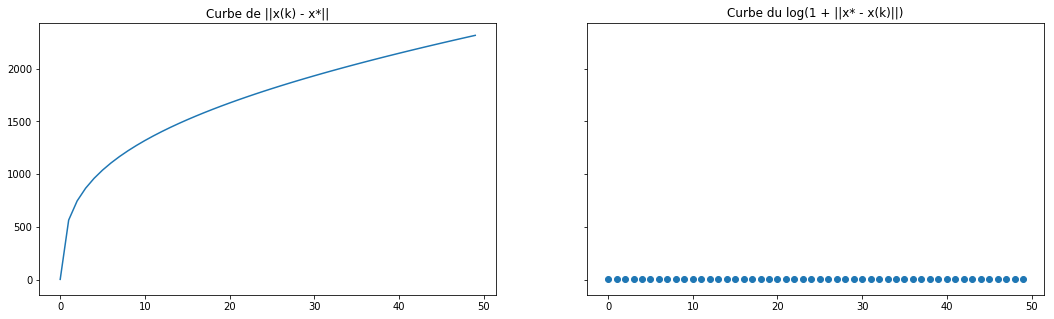

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18, 5))
x = [x for x in range(0, iterations)]
ax1.plot(x, points)
ax1.set_title('Curbe de ||x(k) - x*||')
ax2.scatter(x, logs)
ax2.set_title('Curbe du log(1 + ||x* - x(k)||)')
plt.show()

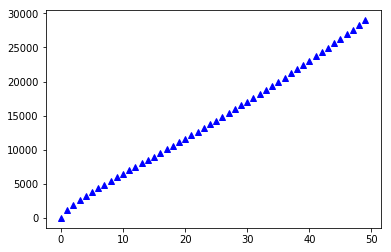

In [21]:
plt.plot([x for x in range(0, iterations)], fs, 'b^')
plt.show()